# Q Learning Algorithm with Epislon Greedy

Reference: 

https://github.com/philtabor/OpenAI-Cartpole

https://www.youtube.com/watch?v=ViwBAK8Hd7Q&t=712s

In [1]:
import gym
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import clear_output
import time
import sys

In [2]:
env = gym.make('CartPole-v0')

MAXSTATES = 10**4
GAMMA = 0.9
ALPHA = 0.01

In [3]:
def max_dict(d):
    max_v = float('-inf')
    for key, val in d.items():
        if val > max_v:
            max_v = val
            max_key = key
    return max_key, max_v

In [4]:
def create_bins():
    # obs[0] -> cart position --- -4.8 - 4.8
    # obs[1] -> cart velocity --- -inf - inf
    # obs[2] -> pole angle    --- -41.8 - 41.8
    # obs[3] -> pole velocity --- -inf - inf

    bins = np.zeros((4,10))
    bins[0] = np.linspace(-4.8, 4.8, 10)
    bins[1] = np.linspace(-5, 5, 10)
    bins[2] = np.linspace(-.418, .418, 10)
    bins[3] = np.linspace(-5, 5, 10)
    return bins

In [5]:
def assign_bins(observation, bins):
    state = np.zeros(4)
    for i in range(4):
        state[i] = np.digitize(observation[i], bins[i])
    return state

In [6]:
def get_state_as_string(state):
    string_state = ''.join(str(int(e)) for e in state)
    return string_state

In [7]:
def get_state_as_string(state):
    string_state = ''.join(str(int(e)) for e in state)
    return string_state

In [8]:
def get_all_states_as_string():
    states = []
    for i in range(MAXSTATES):
        states.append(str(i).zfill(4))
    return states

In [9]:
def initialize_Q():
    Q = {}

    all_states = get_all_states_as_string()
    for state in all_states:
        Q[state] = {}
        for action in range(env.action_space.n):
            Q[state][action] = 0
    return Q

In [10]:
def play_one_game(bins, Q, eps=0.5):
    observation = env.reset()
    done = False
    cnt = 0 # number of moves in an episode
    state = get_state_as_string(assign_bins(observation, bins))
    total_reward = 0

    while not done:
        cnt += 1
        # np.random.randn() seems to yield a random action 50% of the time ?
        if np.random.uniform() < eps:
            act = env.action_space.sample() # epsilon greedy
        else:
            act = max_dict(Q[state])[0]

        observation, reward, done, _ = env.step(act)

        total_reward += reward

        if done and cnt < 200:
            reward = -300

        state_new = get_state_as_string(assign_bins(observation, bins))

        a1, max_q_s1a1 = max_dict(Q[state_new])
        Q[state][act] += ALPHA*(reward + GAMMA*max_q_s1a1 - Q[state][act])
        state, act = state_new, a1

    return total_reward, cnt

In [11]:
def play_many_games(bins, N=10000):
    Q = initialize_Q()

    length = []
    reward = []
    for n in range(N):
        #eps=0.5/(1+n*10e-3)
        eps = 1.0 / np.sqrt(n+1)

        episode_reward, episode_length= play_one_game(bins, Q, eps)

        if n % 100 == 0:
            clear_output(wait=True)
            print("Episode: %d, Epislon: %.4f, Reward %d"%(n,eps,episode_reward))
        length.append(episode_length)
        reward.append(episode_reward)
        
        if (N-n<=10):
            env.render()
            time.sleep(0.01)

    return length, reward, Q

In [12]:
def plot_running_avg(totalrewards):
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(totalrewards[max(0, t-100):(t+1)])
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()

In [13]:
def play_policy(bins,Q,N=1000,render=False):
    totalReward=[]
    steps=[]
    for n in range(N):
        observation=env.reset()
        done=False
        episodeReward=0
        while not done:
            if render:
                env.render()
                time.sleep(0.01)
            state=get_state_as_string(assign_bins(observation, bins))
            act=max_dict(Q[state])[0]
#             print(act)
            observation,reward,done,_=env.step(act)
            episodeReward+=reward
        totalReward.append(episodeReward)
    env.close()
    return totalReward

## Finding Expert Policy

Episode: 9900, Epislon: 0.0100, Reward 200


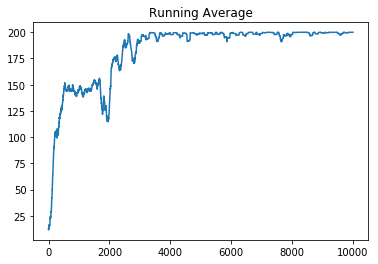

In [14]:
bins = create_bins()
episode_lengths, episode_rewards, expert_Q= play_many_games(bins)

plot_running_avg(episode_rewards)

# Demonstrate Expert Policy

In [15]:
expertReward=play_policy(bins,expert_Q,N=10000,render=False)

Text(0, 0.5, 'Frequency')

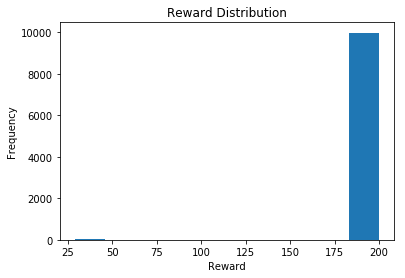

In [16]:
plt.hist(expertReward)
plt.title("Reward Distribution")
plt.xlabel("Reward")
plt.ylabel("Frequency")

In [17]:
expertReward=play_policy(bins,expert_Q,N=5,render=True)

In [18]:
env.close()

# Build IRL Algorithm

In [19]:
def play_policy(bins,Q,N=1000,render=False):
    totalReward=[]
    steps=[]
    for n in range(N):
        observation=env.reset()
        done=False
        episodeReward=0
        while not done:
            if render:
                env.render()
                time.sleep(0.01)
            state=get_state_as_string(assign_bins(observation, bins))
            act=max_dict(Q[state])[0]
#             print(act)
            observation,reward,done,_=env.step(act)
            episodeReward+=reward
        totalReward.append(episodeReward)
    env.close()
    return totalReward

In [29]:
def getFeatureExpectation(Q,N=1000):
    observationSum=np.zeros(4)
    for i in range(N):
        observation=env.reset()
        done=False
        cnt=0
        while not done:
            state=get_state_as_string(assign_bins(observation, bins))
            act=max_dict(Q[state])[0]
            
            observation,reward,done,_=env.step(act)
            observationSum+=(GAMMA**cnt)*observation
            cnt+=1
    featureExpectation=observationSum/N
    
    print("FeatureExpectation: ",featureExpectation)
    return featureExpectation

In [30]:
def irl_play_one_game(bins,weight,Q,eps=0.5):
    observation = env.reset()
    done = False
    cnt = 0 # number of moves in an episode
    state = get_state_as_string(assign_bins(observation, bins))
    total_reward = 0

    while not done:
        cnt += 1
        # np.random.randn() seems to yield a random action 50% of the time ?
        if np.random.uniform() < eps:
            act = env.action_space.sample() # epsilon greedy
        else:
            act = max_dict(Q[state])[0]

        observation, reward, done, _ = env.step(act)
        reward = np.dot(weight,observation)
#         print(reward)
        total_reward += reward

        if done and cnt < 200:
            reward = -300

        state_new = get_state_as_string(assign_bins(observation, bins))

        a1, max_q_s1a1 = max_dict(Q[state_new])
        Q[state][act] += ALPHA*(reward + GAMMA*max_q_s1a1 - Q[state][act])
        state, act = state_new, a1

    return total_reward, cnt

In [31]:
def irl_play_many_games(bins,weight,i,N=10000):
    Q = initialize_Q()

    length = []
    reward = []
    for n in range(N):
        #eps=0.5/(1+n*10e-3)
        eps = 1.0 / np.sqrt(n+1)

        episode_reward, episode_length= irl_play_one_game(bins, weight,Q,eps)

        length.append(episode_length)
        reward.append(episode_reward)
        
    print("Iteration: %d, AvgReward %d"%(i,np.average(reward)))
    return length, reward, Q

In [32]:
expertExpectation=getFeatureExpectation(expert_Q)

FeatureExpectation:  [-0.11890172 -0.65677369  0.30228896  1.77282676]


In [ ]:
#either terminate with margin of 0.001 or 50 iterations
epislon=0.001
N=50

weight=[]
featureExpectation=[]
featureExpectationBar=[]
learnedQ=[]
margin=[]

for i in range(N):
    if i==0: #step1, initialization
        initialQ=initialize_Q() #give random initial policy
        featureExpectation.append(getFeatureExpectation(initialQ))
        learnedQ.append(initialQ) #put in the initial policy
        weight.append(np.zeros(4)) #put in a dummy weight
        margin.append(10000) #put in a dummy margin
    elif i==1:#first iter of step 2
        featureExpectationBar.append(featureExpectation[i-1])
        weight.append(expertExpectation-featureExpectation[i-1])
        margin.append(norm((expertExpectation-featureExpectation[i-1]),2))
    else: #iter 2 and on of step 2
        A=featureExpectationBar[i-2]
        B=featureExpectation[i-1]-A
        C=expertExpectation-featureExpectationBar[i-2]
        featureExpectationBar.append(A+(np.dot(B,C)/np.dot(B,B))*(B))
        
        weight.append(expertExpectation-featureExpectationBar[i-1])
        margin.append(norm((expertExpectation-featureExpectationBar[i-1]),2))
    
    print("margin: ",margin[i])
    print("weight: ",weight[i])
    print("")
    if (margin[i]<=epislon): #step3,terminate condition
        break
        
    #step4
    episode_lengths, episode_rewards, learnedQ_i= irl_play_many_games(bins,weight[i],i)
    learnedQ.append(learnedQ_i)
    
    #step5
    featureExpectation.append(getFeatureExpectation(learnedQ[i]))


FeatureExpectation:  [-0.27132119 -5.44841817  0.39861475  8.32280642]
margin:  10000
weight:  [0. 0. 0. 0.]

Iteration: 0, AvgReward 0
FeatureExpectation:  [-0.26902293 -5.46157348  0.3971718   8.34545542]
margin:  8.117548933134906
weight:  [ 0.15241947  4.79164448 -0.09632579 -6.54997966]

Iteration: 1, AvgReward -285
FeatureExpectation:  [ 0.10183775  0.57086511 -0.28520359 -1.60775857]
margin:  1.3232297561461388
weight:  [ 0.85142992  0.79049547 -0.53519695  0.33865205]

Iteration: 2, AvgReward 127
FeatureExpectation:  [ 0.27970166  2.07981328 -0.82004337 -5.22590262]
margin:  1.2150280530865203
weight:  [ 0.70978587  0.52388021 -0.3868787   0.74052116]

Iteration: 3, AvgReward 152


In [ ]:
bestPolicy=learnedQ[-1]
irlReward=play_policy(bins,bestPolicy,N=10000,render=False)

In [ ]:
plt.hist(irlReward)
plt.title("iRL Reward Distribution")
plt.xlabel("Reward")
plt.ylabel("Frequency")

# Playground

In [35]:
a=[1,2,3,4,5]

In [36]:
a

[1, 2, 3, 4, 5]

In [37]:
a[-1]

5